In [1]:
%matplotlib inline
import glob, re
import numpy as np
import pandas as pd
import xgboost
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas_profiling as pdp
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/jordanvidal/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jordanvidal/python3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/jordanvidal/python3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be rem

In [2]:
data = {
    'tra': pd.read_csv('data/air_visit_data.csv.zip', compression="zip"),
    'as': pd.read_csv('data/air_store_info.csv.zip', compression="zip"),
    'hs': pd.read_csv('data/hpg_store_info.csv.zip', compression="zip"),
    'ar': pd.read_csv('data/air_reserve.csv.zip', compression="zip"),
    'hr': pd.read_csv('data/hpg_reserve.csv.zip', compression="zip"),
    'id': pd.read_csv('data/store_id_relation.csv.zip', compression="zip"),
    'tes': pd.read_csv('data/sample_submission.csv.zip', compression="zip"),
    'hol': pd.read_csv('data/date_info.csv.zip', compression="zip").rename(columns={'calendar_date':'visit_date'})
    }

In [10]:
#pdp.ProfileReport(data['ar'])

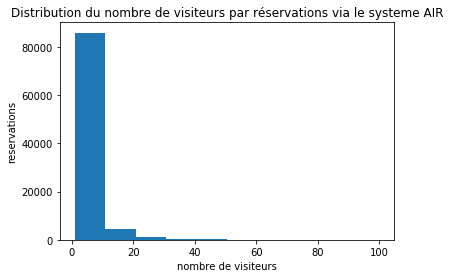

In [3]:
plot2 = plt.hist(data['ar']['reserve_visitors'])
plt.ylabel('reservations')
plt.xlabel('nombre de visiteurs')
plt.title('Distribution du nombre de visiteurs par réservations via le systeme AIR')

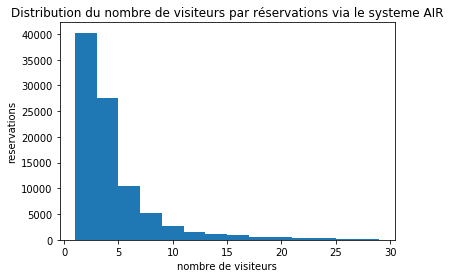

In [4]:
plot8 = plt.hist(data['ar']['reserve_visitors'], bins=range(1,30,2))
plt.ylabel('reservations')
plt.xlabel('nombre de visiteurs')
plt.title('Distribution du nombre de visiteurs par réservations via le systeme AIR')

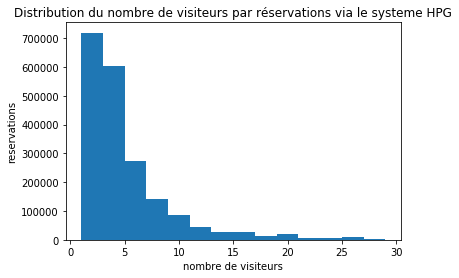

In [5]:
plot3 = plt.hist(data['hr']['reserve_visitors'], bins=range(1,30,2))
plt.ylabel('reservations')
plt.xlabel('nombre de visiteurs')
plt.title('Distribution du nombre de visiteurs par réservations via le systeme HPG')

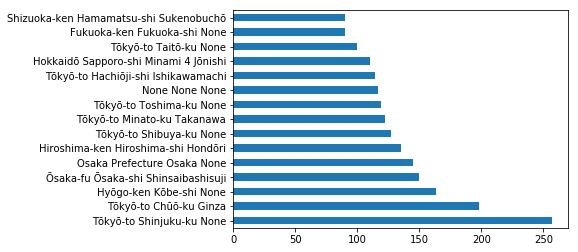

In [6]:
han = data['hs']['hpg_area_name'].value_counts().nlargest(15)
han.plot(kind = "barh")
plt.savefig('hs_hpg_area_name.png', bbox_inches='tight')

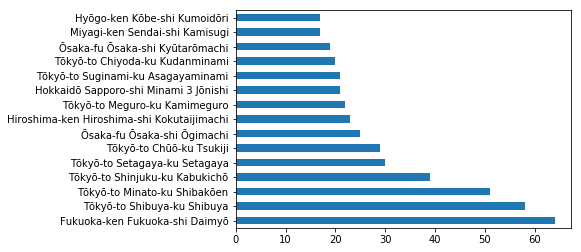

In [7]:
han = data['as']['air_area_name'].value_counts().nlargest(15)
han.plot(kind = "barh")
plt.savefig('as_air_area_name.png', bbox_inches='tight')

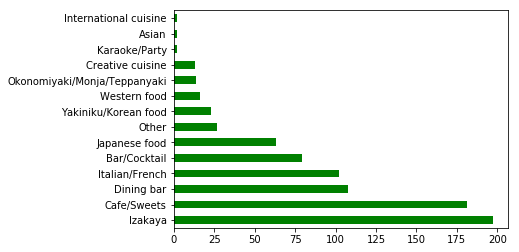

In [8]:
c = data['as']['air_genre_name'].value_counts()
c.plot(kind="barh", color = "green")
plt.savefig('as_air_genre_name.png', bbox_inches='tight')

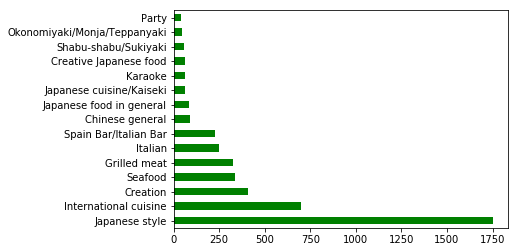

In [9]:
c932 = data['hs']['hpg_genre_name'].value_counts().nlargest(15)
c932.plot(kind="barh", color = "green")
plt.savefig('hs_hpg_genre_name.png', bbox_inches='tight')

In [16]:
data['tra'].shape

(252108, 3)

In [17]:
data['tra']

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
5,air_ba937bf13d40fb24,2016-01-19,9
6,air_ba937bf13d40fb24,2016-01-20,31
7,air_ba937bf13d40fb24,2016-01-21,21
8,air_ba937bf13d40fb24,2016-01-22,18
9,air_ba937bf13d40fb24,2016-01-23,26


In [19]:
data['tes']

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0
5,air_00a91d42b08b08d9_2017-04-28,0
6,air_00a91d42b08b08d9_2017-04-29,0
7,air_00a91d42b08b08d9_2017-04-30,0
8,air_00a91d42b08b08d9_2017-05-01,0
9,air_00a91d42b08b08d9_2017-05-02,0


In [20]:
data['id'].shape

(150, 2)

In [22]:
data['id'].head(10)

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7
5,air_a38f25e3399d1b25,hpg_50378da9ffb9b6cd
6,air_3c938075889fc059,hpg_349b1b92f98b175e
7,air_68301bcb11e2f389,hpg_2c09f3abb2220659
8,air_5f6fa1b897fe80d5,hpg_40aff6385800ebb1
9,air_00a91d42b08b08d9,hpg_fbe603376b5980fc


In [24]:
print(min(data['hol']['visit_date']))

2016-01-01
